# Predicting Subreddits from Post Titles

---
### Data
The data for this project includes all posts made to tech related subreddits in December 2016

### Goal
The goal of this project is to use natural language processing to accurately predict the subreddit based on the title of a post.

## Notebook Contents
---
- [Exploratory Data Analysis](#eda)
- [Feature Engineering](#fe)
- [Downsample Majority Classes](#downsample)
- [Random Forest Classifier](#rfc)
- [Gradient Boosting Classifier](#gbc)
- [Downsampled Random Forest Classifier](#resample rfc)
- [Downsampled Gradient Boost Classifier](#resample gbc)
- [Word Frequency by Genre](#frequency) 
- [Conclusions & Takeaways](#conclusions)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import roc_curve, auc

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<a id='eda'></a>
## Exploratory Data Analysis

In [2]:
df = pd.read_csv('reddit_posts.csv')
print(df.shape)
df.head(2)

(26688, 53)


,adserver_click_url,adserver_imp_pixel,archived,author,author_flair_css_class,author_flair_text,contest_mode,created_utc,disable_comments,distinguished,...,spoiler,stickied,subreddit,subreddit_id,third_party_tracking,third_party_tracking_2,thumbnail,title,ups,url
0,NaN,NaN,False,johnnyawesome0,NaN,NaN,False,1480697304,NaN,NaN,...,False,False,techsupport,t5_2qioo,NaN,NaN,self,Help with audio set-up,1.0,https://www.reddit.com/r/techsupport/comments/...
1,NaN,NaN,False,Silverfin113,NaN,NaN,False,1480697424,NaN,NaN,...,False,False,learnprogramming,t5_2r7yd,NaN,NaN,self,Optimizing code for speed,23.0,https://www.reddit.com/r/learnprogramming/comm...


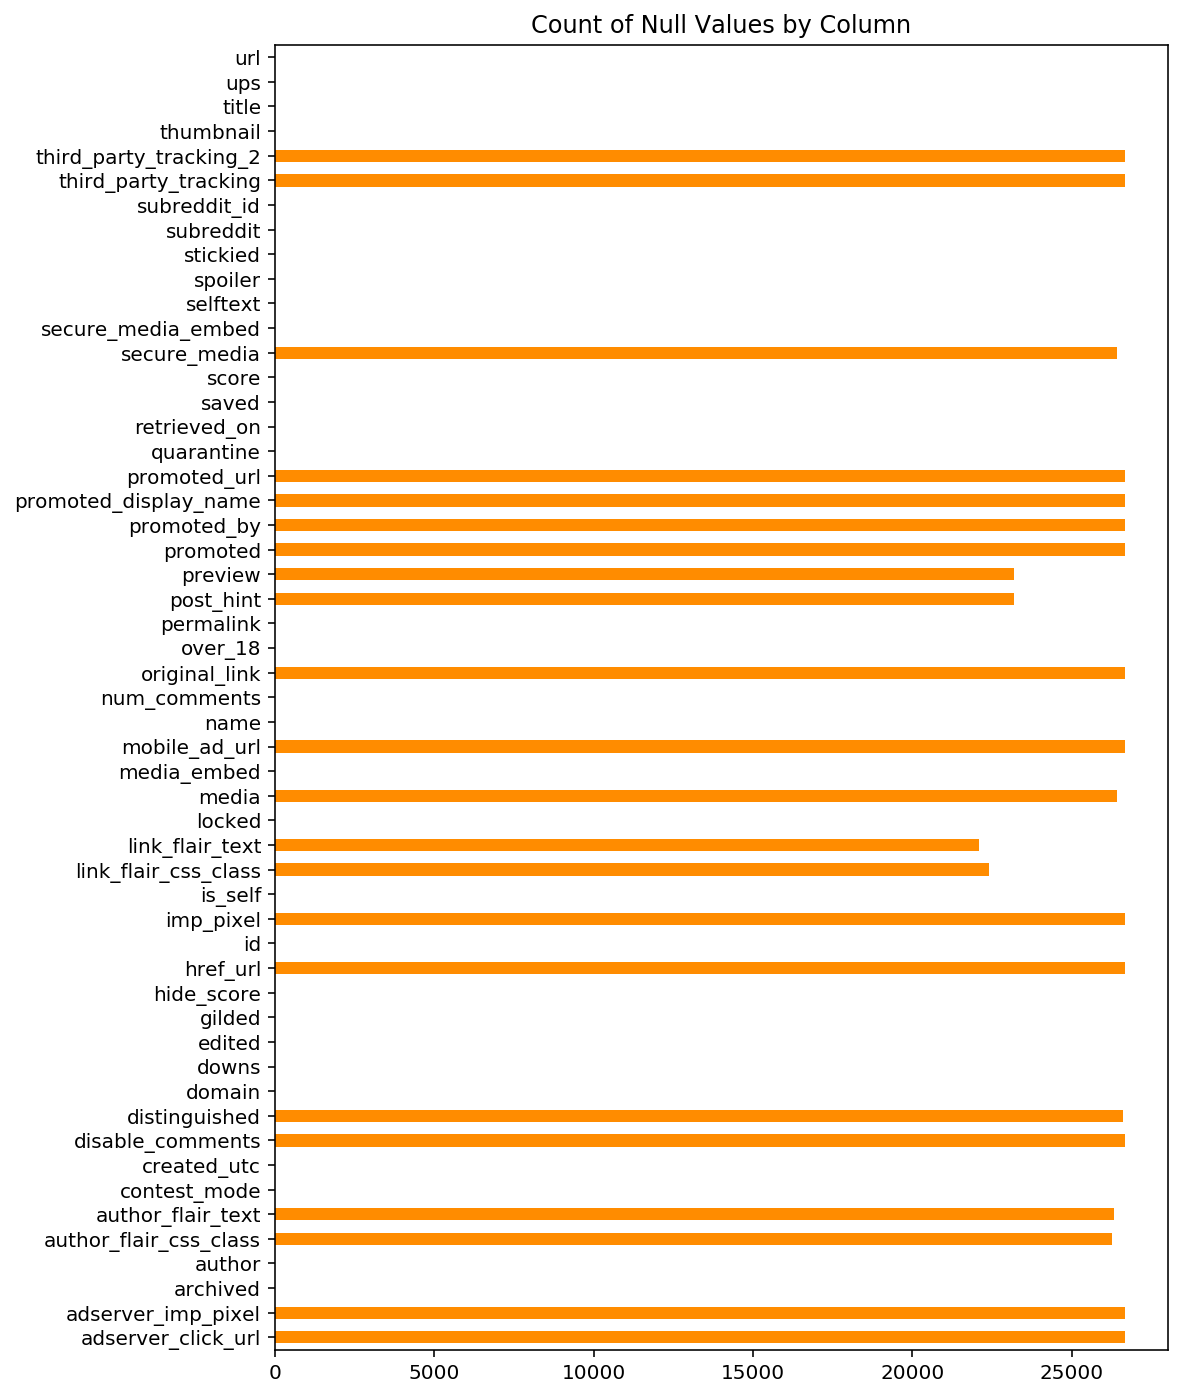

In [3]:
#look at null values
plt.subplots(figsize=(8,12))
plt.title('Count of Null Values by Column')
df.isnull().sum().plot(kind='barh', color = 'DarkOrange');

The columns that contain null values are almost entirely null. Due to this there is no reasonable way to impute missing data so I deciced to remove the null columns from the dataset.

In [4]:
df = df.dropna(axis=1)

In [5]:
print(df.shape)
# look at remaining columns
print(df.columns)

(26688, 31)
Index(['archived', 'author', 'contest_mode', 'created_utc', 'domain', 'downs',
       'edited', 'gilded', 'hide_score', 'id', 'is_self', 'locked',
       'media_embed', 'name', 'num_comments', 'over_18', 'permalink',
       'quarantine', 'retrieved_on', 'saved', 'score', 'secure_media_embed',
       'selftext', 'spoiler', 'stickied', 'subreddit', 'subreddit_id',
       'thumbnail', 'title', 'ups', 'url'],
      dtype='object')


In [6]:
# create a new dataframe with potentially relevant columns
df = df[['selftext','subreddit','title','ups']]
df.head()

,selftext,subreddit,title,ups
0,I have a Sony surround sound system for a blu-...,techsupport,Help with audio set-up,1.0
1,I've written what seems to be a prohibitively ...,learnprogramming,Optimizing code for speed,23.0
2,"I'm writing an article called ""Video Games Tha...",gamedev,Seeking Tales of Development Woe (and Triumph)...,12.0
3,[deleted],learnprogramming,[Java] Finding smallest value in an array,0.0
4,I have the following representation of argumen...,learnpython,currying functions using functools,6.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26688 entries, 0 to 26687
Data columns (total 4 columns):
selftext     26688 non-null object
subreddit    26688 non-null object
title        26688 non-null object
ups          26688 non-null float64
dtypes: float64(1), object(3)
memory usage: 834.1+ KB


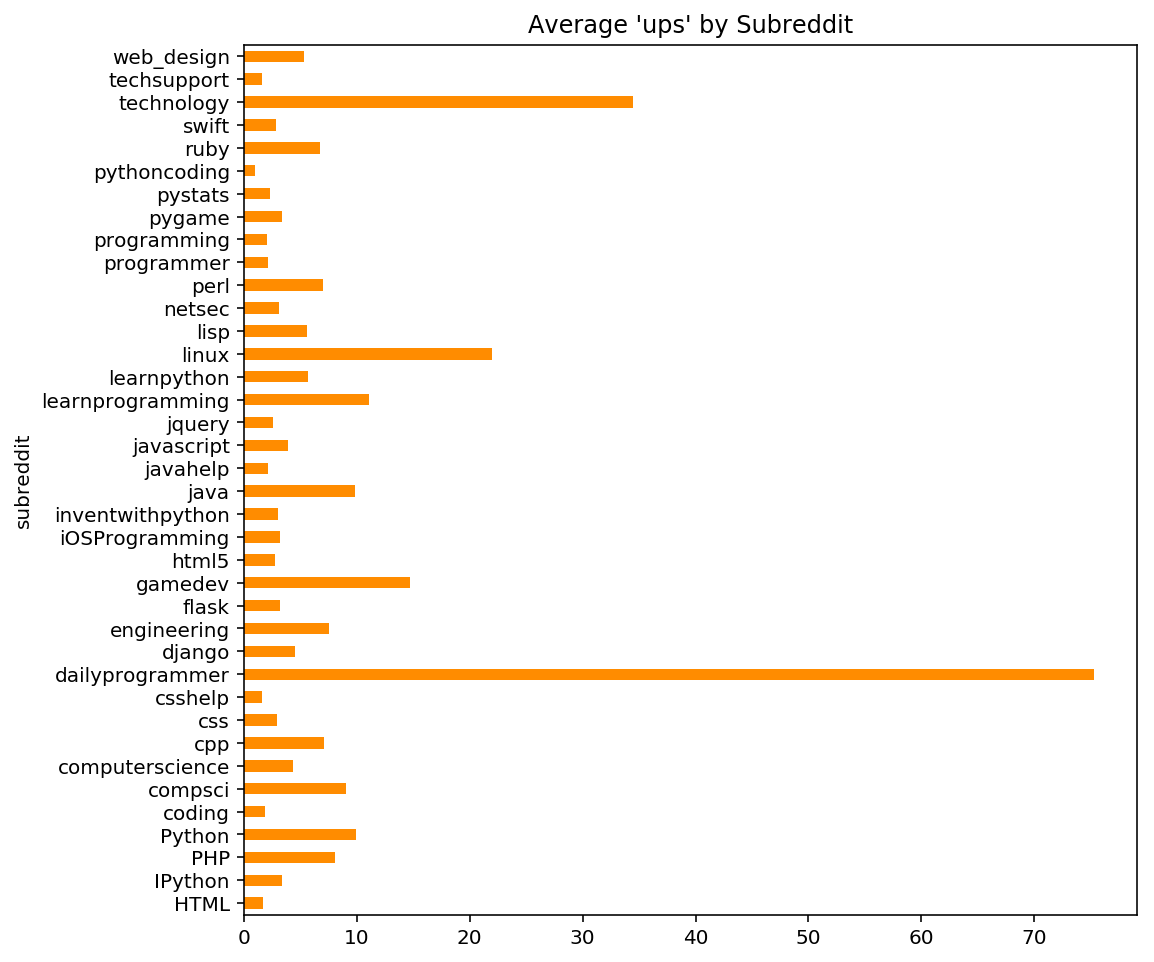

In [8]:
# what does our data look like
plt.subplots(figsize=(8,8))
plt.title("Average 'ups' by Subreddit")
df.groupby('subreddit').mean().ups.plot(kind='barh', color='DarkOrange');

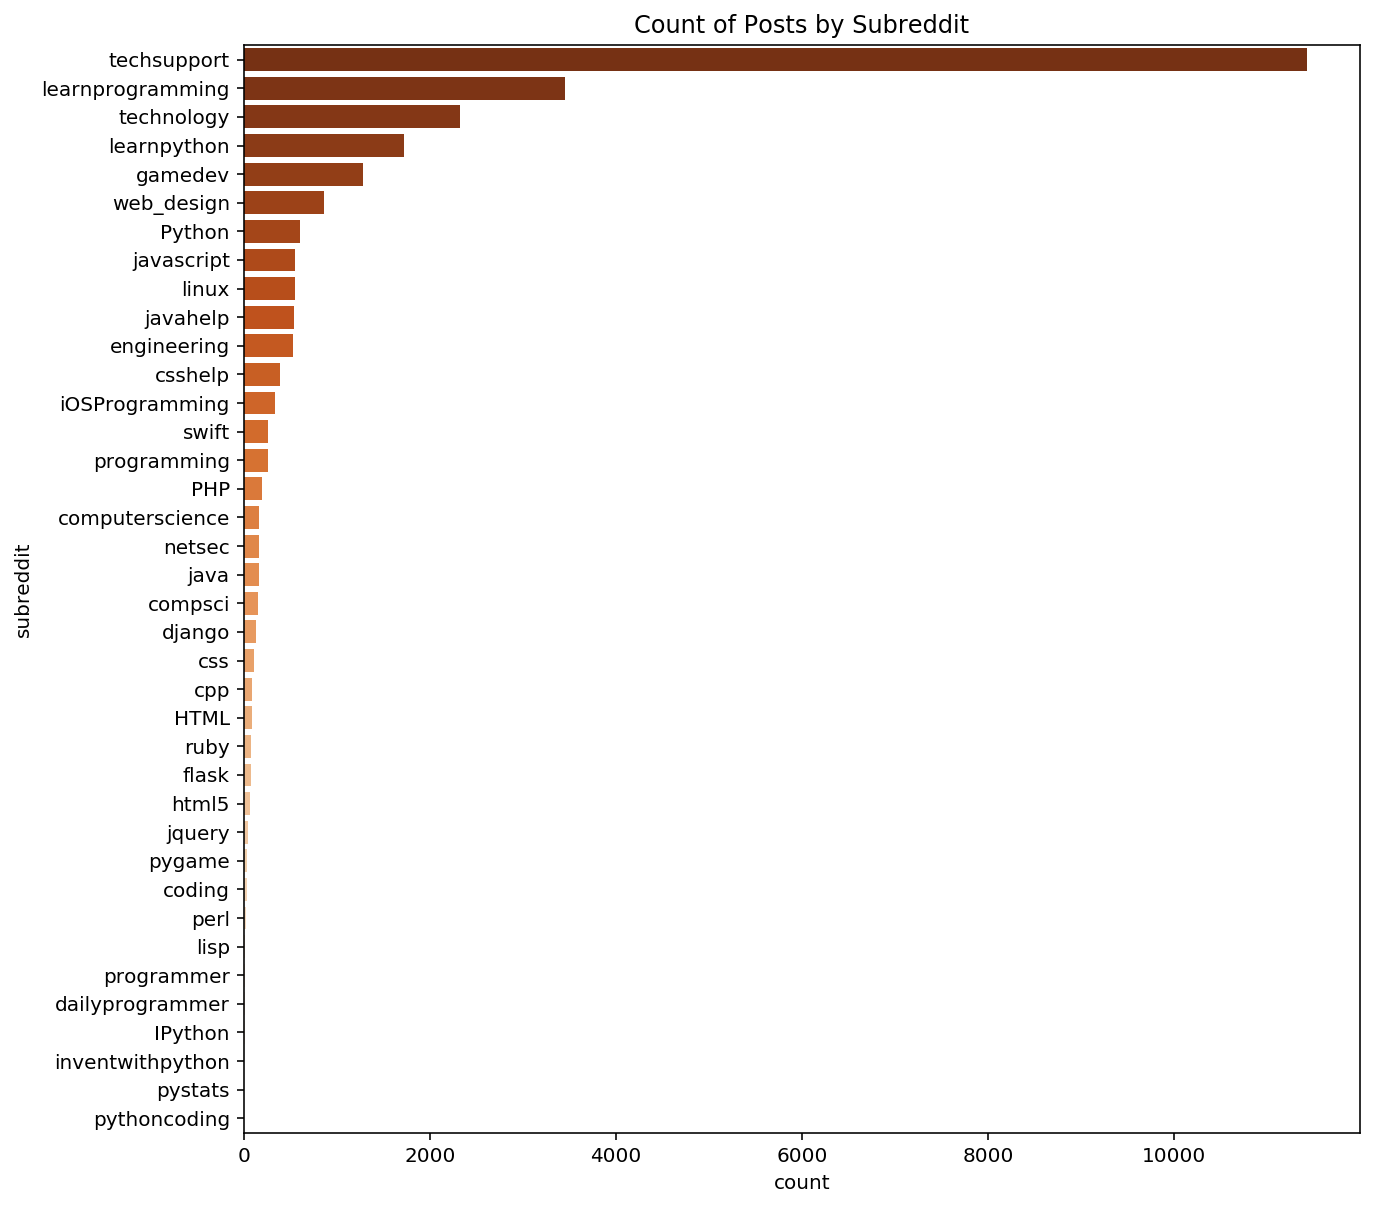

In [9]:
# how is the data distributed between the subreddits
plt.subplots(figsize=(10,10)) 
plt.xticks(ha='center')
plt.title("Count of Posts by Subreddit")
sns.countplot(y='subreddit',data = df, palette='Oranges_r', order = df.subreddit.value_counts().index);

In [10]:
# distribution is disproportionately techsupport
# consolidate similar subreddits
subreddit_dict = {'pythoncoding':'Python','pystats':'Python','inventwithpython':'Python',
                 'IPython':'Python','pygame':'Python','dailyprogrammer':'programming',
                 'programmer':'programming','javahelp':'javascript'}
df.subreddit.replace(subreddit_dict, inplace=True)
#limit the subreddits to the ones with the largest counts
df = df[(df.subreddit.isin(['techsupport','learnprogramming','gamedev',
                            'learnpython','linux','technology','web_design',
                            'engineering','javascript','iOSPrograming']))]

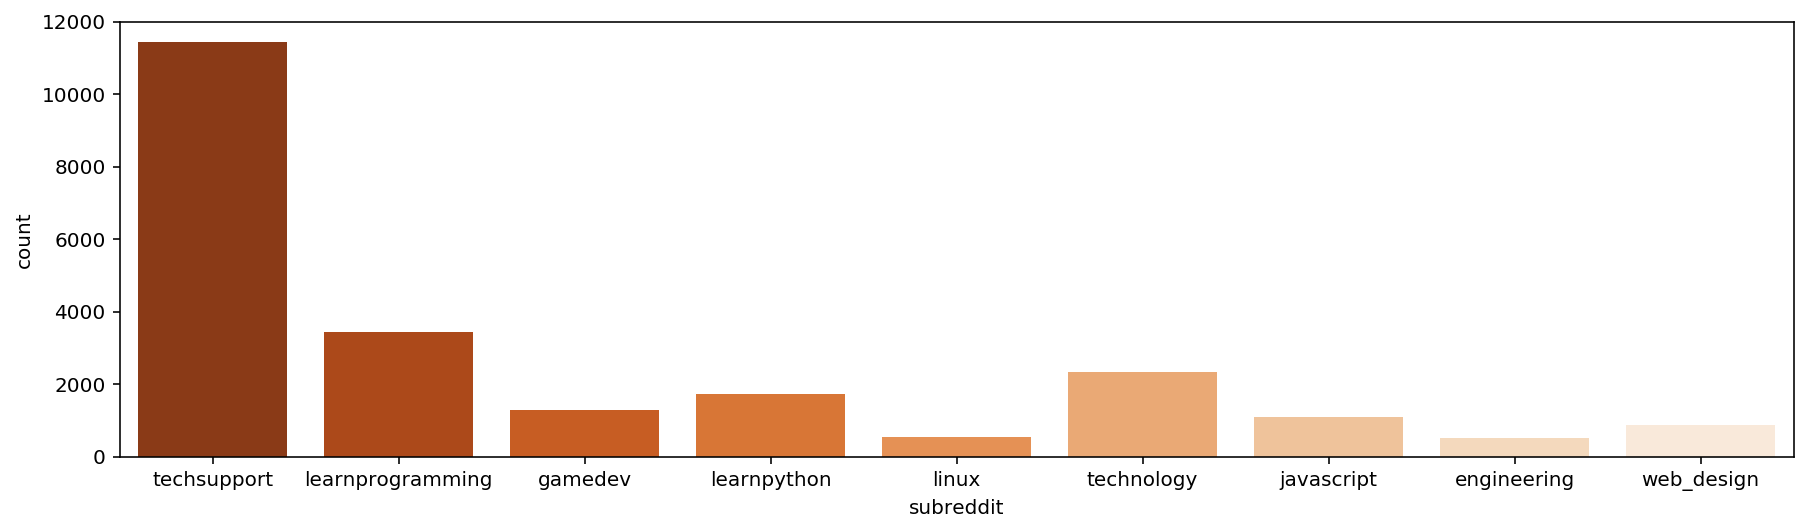

In [11]:
plt.subplots(figsize=(15,4)) 
plt.xticks(ha='center')
sns.countplot(x='subreddit', data = df, palette='Oranges_r');

<a id='fe'></a>
# Feature Engineering

In [12]:
# encode the subreddit column
le = LabelEncoder()
le.fit(df['subreddit'])
df['sub_code']=le.transform(df['subreddit'])

In [13]:
sub_codes = df.groupby(['subreddit','sub_code']).count()
sub_codes = sub_codes.reset_index()[['subreddit','sub_code', 'ups']]
sub_codes

,subreddit,sub_code,ups
0,engineering,0,525
1,gamedev,1,1281
2,javascript,2,1082
3,learnprogramming,3,3448
4,learnpython,4,1724
5,linux,5,545
6,technology,6,2321
7,techsupport,7,11423
8,web_design,8,864


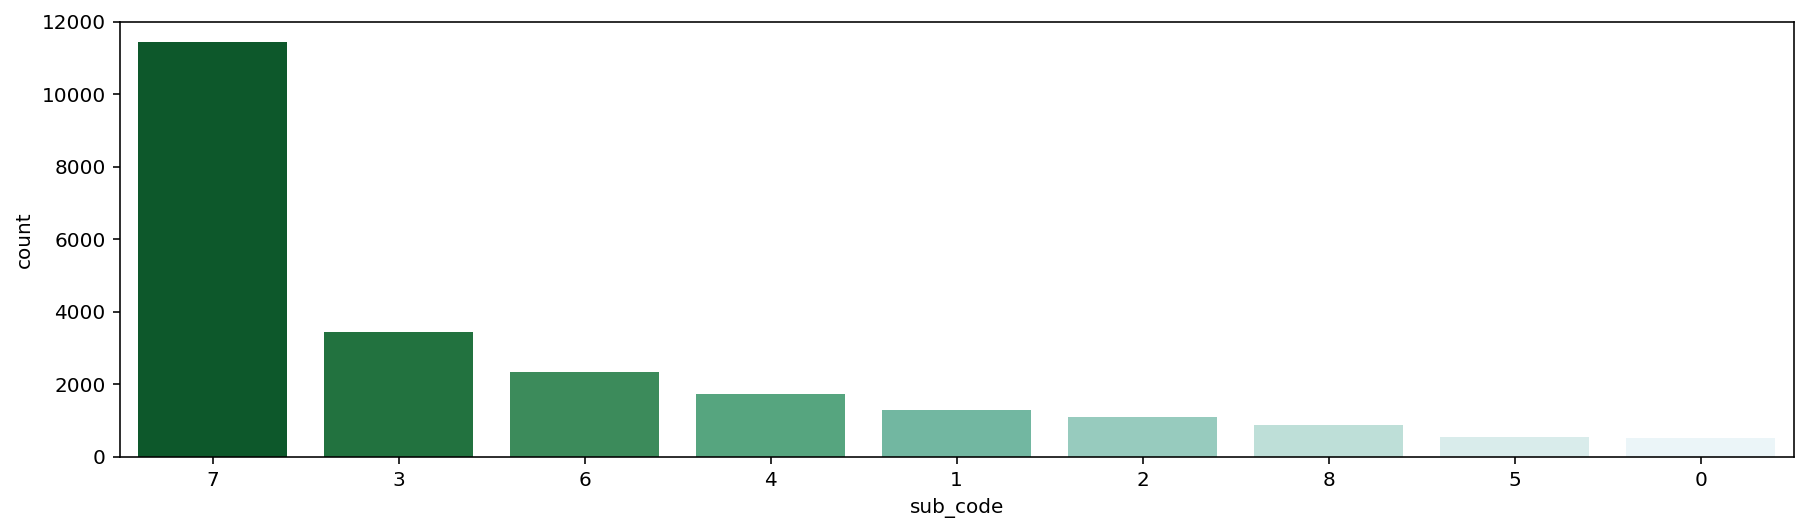

In [14]:
plt.subplots(figsize=(15,4)) 
plt.xticks(rotation=0, ha='center')
sns.countplot(x='sub_code', data = df, palette='BuGn_r',order = df.sub_code.value_counts().index);

<a id='downsample'></a>
# Downsample Majority Class

Data is disproportionately techsupport. The imbalanced data may cause models to overfit so I downsampled largest genres (techsupport & learn\_programming) and created a downsampled version of the data for future models

Downsample data using sklearn.utils.resample because of its simiplicity. May use penalized SVM or SMOTE for future resampling methods.

In [15]:
from sklearn.utils import resample

df_majority = df[df.sub_code == 7]
df_minority = df[df.sub_code != 7]
df_majority_downsampled = resample(df_majority, replace=False, n_samples=2500, random_state=240)
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

df_majority = df_downsampled[df_downsampled.sub_code == 3]
df_minority = df_downsampled[df_downsampled.sub_code != 3]
df_majority_downsampled = resample(df_majority, replace=False, n_samples=2500, random_state=240)
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

In [16]:
sub_codes_down = df_downsampled.groupby(['subreddit','sub_code']).count()
sub_codes_down = sub_codes_down.reset_index()[['subreddit','sub_code', 'ups']]
sub_codes_down

,subreddit,sub_code,ups
0,engineering,0,525
1,gamedev,1,1281
2,javascript,2,1082
3,learnprogramming,3,2500
4,learnpython,4,1724
5,linux,5,545
6,technology,6,2321
7,techsupport,7,2500
8,web_design,8,864


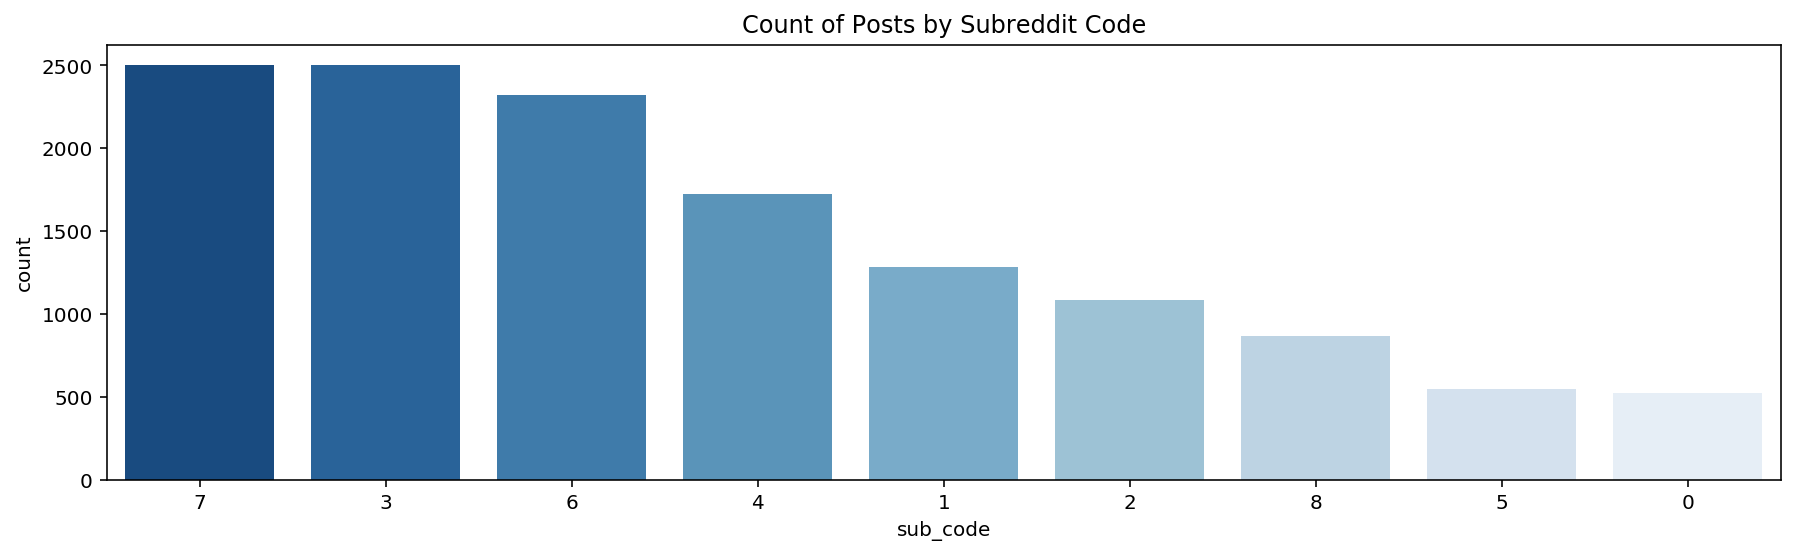

In [17]:
plt.subplots(figsize=(15,4)) 
plt.xticks(rotation=0, ha='center')
plt.title("Count of Posts by Subreddit Code")
sns.countplot(x='sub_code', data = df_downsampled, palette='Blues_r', order = [7,3,6,4,1,2,8,5,0]);

<a id='target'></a>
# Target Variable

In [18]:
y = df['sub_code']
X = df['title']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=240, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape )

(15552,) (7661,) (15552,) (7661,)


In [19]:
# Subreddits are dispproportionately techsupport
# Baseline for predicting subreddit = techsupport
baseline = y.value_counts()[7]/sum(y.value_counts())
baseline

0.4920949467970534

<a id='rfc'></a>
# Random Forest Classifier

In [20]:
pipe = Pipeline([
    ('tfidf',TfidfVectorizer(stop_words='english')),
    ('rfc',RandomForestClassifier())
])

rfc_params = {
    'tfidf__max_features':[1000, 2000, 3000, 4000],
    'tfidf__use_idf':[True, False],
    'rfc__n_estimators':[150,200,250],
    'rfc__max_depth':[350,400,450,500]
}

In [21]:
rfc_gs = GridSearchCV(pipe, cv = 2, param_grid=rfc_params)
rfc_gs.fit(X_train, y_train)

print("Best Score: ",rfc_gs.best_score_)
print("Best Params: ", rfc_gs.best_params_)

Best Score:  0.689493312757
Best Params:  {'rfc__max_depth': 500, 'rfc__n_estimators': 200, 'tfidf__max_features': 4000, 'tfidf__use_idf': True}


In [22]:
print("Train score: ",rfc_gs.score(X_train, y_train))
print("Test score: ", rfc_gs.score(X_test, y_test))
print(classification_report(y_test, rfc_gs.predict(X_test)))

Train score:  0.964441872428
Test score:  0.712570160553
             precision    recall  f1-score   support

          0       0.75      0.32      0.45       173
          1       0.74      0.53      0.62       423
          2       0.49      0.19      0.27       357
          3       0.60      0.58      0.59      1138
          4       0.59      0.43      0.50       569
          5       0.74      0.39      0.51       180
          6       0.76      0.51      0.61       766
          7       0.75      0.95      0.84      3770
          8       0.60      0.52      0.56       285

avg / total       0.70      0.71      0.69      7661



In [23]:
conmat = np.array(confusion_matrix(y_test, rfc_gs.predict(X_test)))
confusion = pd.DataFrame(conmat,
                         index = ['is_engineering', 'is_gamedev','is_javascript','is_learnprogramming',
                                  'is_learnpython','is_linux','is_technology','is_techsupport','is_web_design'],
                        columns=['pred_engineering', 'pred_gamedev','pred_javascript','pred_learnprogramming',
                                 'pred_learnpython','pred_linux','pred_technology','pred_techsupport',
                                 'pred_web_design'])
confusion

,pred_engineering,pred_gamedev,pred_javascript,pred_learnprogramming,pred_learnpython,pred_linux,pred_technology,pred_techsupport,pred_web_design
is_engineering,55,3,2,18,3,0,15,73,4
is_gamedev,1,223,3,54,4,0,9,119,10
is_javascript,1,10,68,114,33,2,2,115,12
is_learnprogramming,10,24,40,655,101,7,24,247,30
is_learnpython,0,7,13,127,247,4,5,158,8
is_linux,0,3,0,13,4,71,3,80,6
is_technology,6,8,2,29,2,1,393,309,16
is_techsupport,0,20,4,56,18,11,49,3598,14
is_web_design,0,4,6,30,7,0,19,70,149


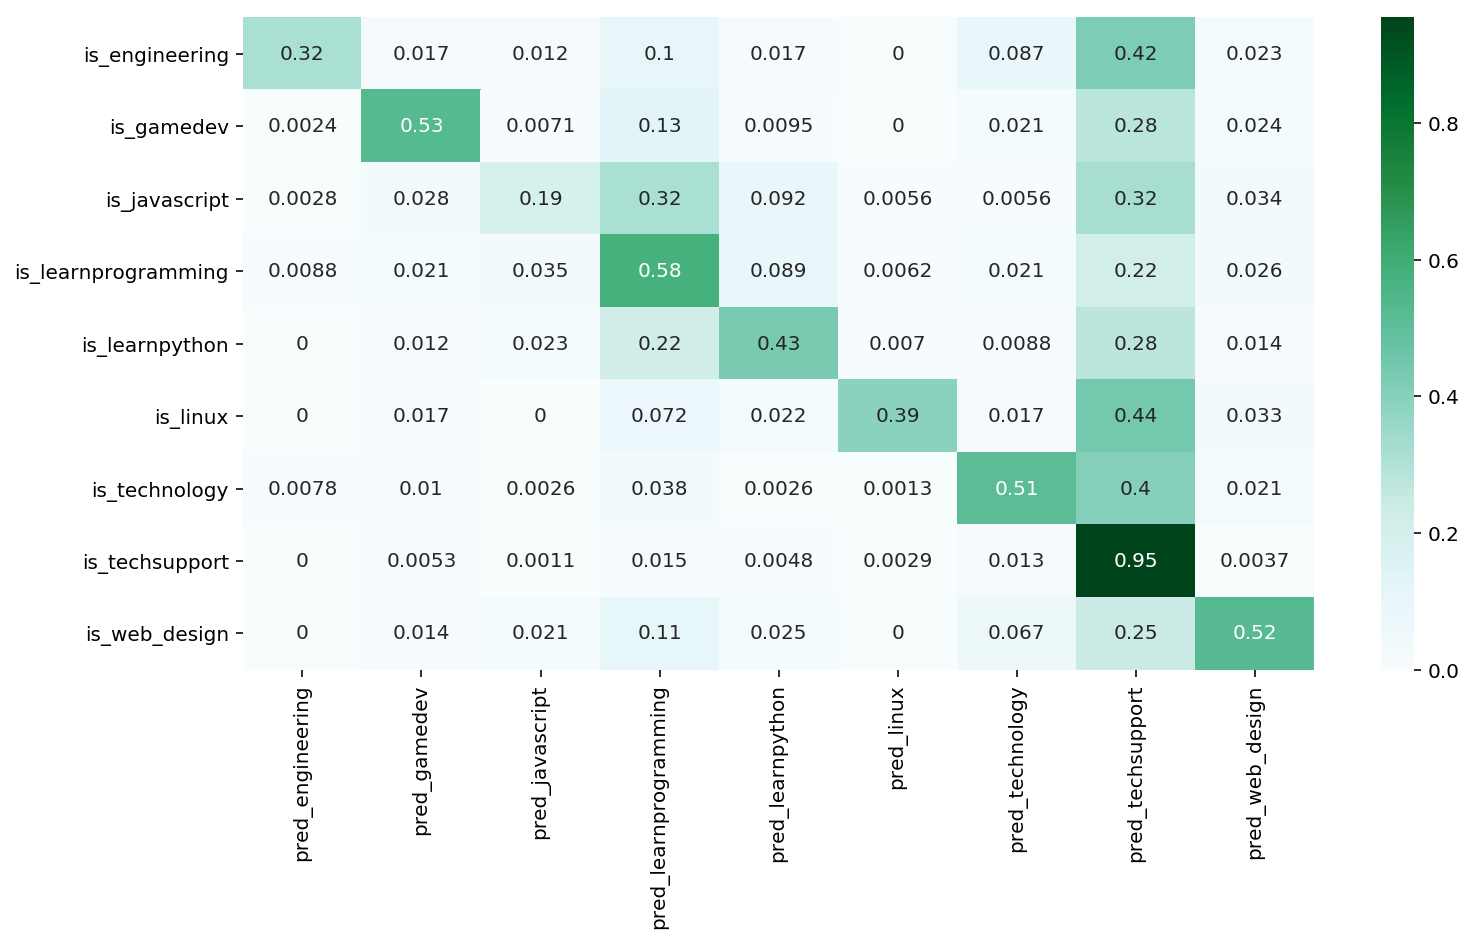

In [24]:
plt.subplots(figsize=(12,6))
sns.heatmap(confusion.apply(lambda x: x/x.sum(),axis=1), annot=True, cmap = 'BuGn')
None

### Model is overpredicting _techsupport_. This is expected due to the imbalanced nature of the data. However, for most of the subreddits with the exception of _javascript_ & _python_ are being predicted correctly when they're not being predicted as _techsupport_ .

<a id='gbc'></a>
# Gradient Boosting Classifier

In [26]:
pipe = Pipeline([
    ('tfidf',TfidfVectorizer(stop_words='english')),
    ('gbc',GradientBoostingClassifier())
     ])

gbc_params = {
    'tfidf__max_features':[3000, 3500, 4000],
    'tfidf__use_idf':[True, False],
    'gbc__learning_rate':[0.05, 0.1, 0.15],
    'gbc__n_estimators':[100,150,200,250],
    'gbc__min_samples_leaf':[1,2]
}

In [27]:
gbc_gs = GridSearchCV(pipe, cv = 2, param_grid = gbc_params)
gbc_gs.fit(X_train, y_train)

print("Best Score: ",gbc_gs.best_score_)
print("Best Params: ", gbc_gs.best_params_)

Best Score:  0.684992283951
Best Params:  {'gbc__learning_rate': 0.15, 'gbc__min_samples_leaf': 2, 'gbc__n_estimators': 250, 'tfidf__max_features': 4000, 'tfidf__use_idf': False}


In [28]:
print("Train score: ",gbc_gs.score(X_train, y_train))
print("Test score: ", gbc_gs.score(X_test, y_test))
print(classification_report(y_test, gbc_gs.predict(X_test)))

Train score:  0.834490740741
Test score:  0.70539094113
             precision    recall  f1-score   support

          0       0.49      0.38      0.43       173
          1       0.74      0.52      0.61       423
          2       0.53      0.27      0.36       357
          3       0.67      0.51      0.58      1138
          4       0.67      0.43      0.53       569
          5       0.53      0.49      0.51       180
          6       0.75      0.46      0.57       766
          7       0.73      0.96      0.83      3770
          8       0.60      0.51      0.55       285

avg / total       0.70      0.71      0.68      7661



In [29]:
conmat = np.array(confusion_matrix(y_test, gbc_gs.predict(X_test)))
confusion = pd.DataFrame(conmat,
                         index = ['is_engineering', 'is_gamedev','is_javascript','is_learnprogramming',
                                  'is_learnpython','is_linux','is_technology','is_techsupport','is_web_design'],
                        columns=['pred_engineering', 'pred_gamedev','pred_javascript','pred_learnprogramming',
                                 'pred_learnpython','pred_linux','pred_technology','pred_techsupport',
                                 'pred_web_design'])
confusion

,pred_engineering,pred_gamedev,pred_javascript,pred_learnprogramming,pred_learnpython,pred_linux,pred_technology,pred_techsupport,pred_web_design
is_engineering,66,4,1,8,3,0,12,77,2
is_gamedev,7,221,3,36,2,3,10,133,8
is_javascript,2,9,97,94,18,5,6,115,11
is_learnprogramming,24,20,55,577,88,14,20,311,29
is_learnpython,3,12,14,91,245,9,5,182,8
is_linux,1,2,0,6,0,88,4,75,4
is_technology,24,6,5,13,2,12,354,333,17
is_techsupport,8,20,6,23,6,33,47,3611,16
is_web_design,1,3,3,19,0,1,11,102,145


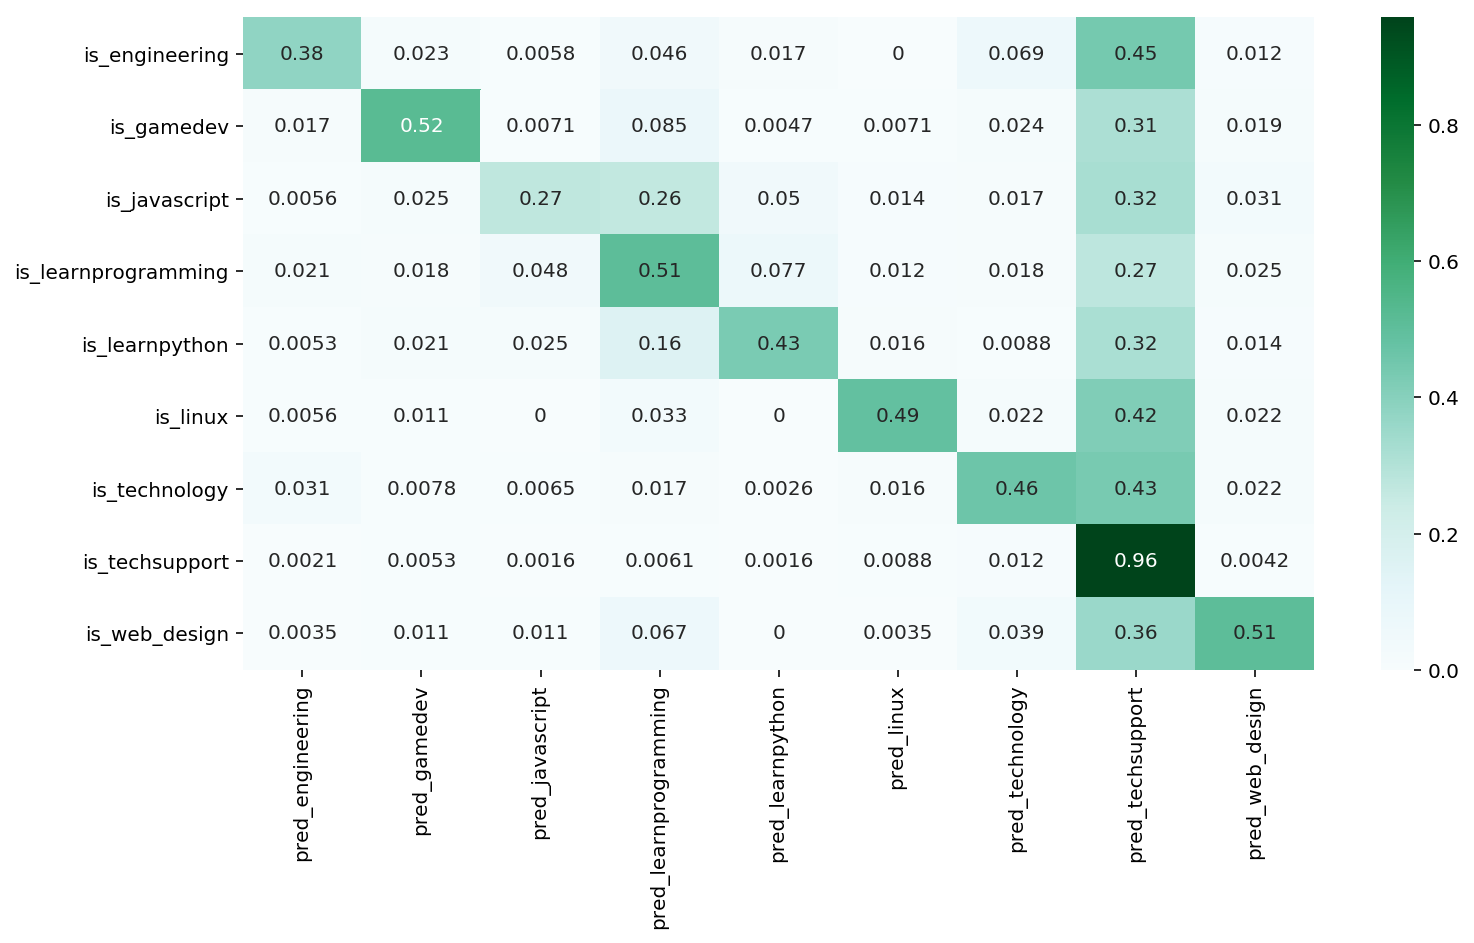

In [30]:
plt.subplots(figsize=(12,6))
sns.heatmap(confusion.apply(lambda x: x/x.sum(),axis=1), annot=True, cmap = 'BuGn')
None

<a id='resample'></a>
# Resampled Target

In [31]:
y_down = df_downsampled['sub_code']
X_down = df_downsampled['title']

Xdown_train, Xdown_test, ydown_train, ydown_test = train_test_split(X_down, y_down, test_size=0.33, 
                                                                    random_state=240, stratify=y_down)
print(Xdown_train.shape, Xdown_test.shape, ydown_train.shape, ydown_test.shape )

(8939,) (4403,) (8939,) (4403,)


In [32]:
baseline = y_down.value_counts()[7]/sum(y_down.value_counts())
baseline

0.18737820416729126

<a id='resample rfc'></a>
# Downsampled Random Forest Classifier

In [33]:
# Using the Random Forest Classifier Gridsearch defined above
rfc_gs.fit(Xdown_train, ydown_train)

print("Best Score: ",rfc_gs.best_score_)
print("Best Params: ", rfc_gs.best_params_)

Best Score:  0.576686430249
Best Params:  {'rfc__max_depth': 450, 'rfc__n_estimators': 150, 'tfidf__max_features': 4000, 'tfidf__use_idf': False}


In [34]:
print("Train score: ",rfc_gs.score(Xdown_train, ydown_train))
print("Test score: ", rfc_gs.score(Xdown_test, ydown_test))
print(classification_report(ydown_test, rfc_gs.predict(Xdown_test)))

Train score:  0.969124063094
Test score:  0.609357256416
             precision    recall  f1-score   support

          0       0.69      0.39      0.50       173
          1       0.71      0.63      0.67       423
          2       0.43      0.27      0.33       357
          3       0.54      0.53      0.53       825
          4       0.52      0.57      0.54       569
          5       0.78      0.48      0.60       180
          6       0.58      0.78      0.66       766
          7       0.75      0.78      0.76       825
          8       0.64      0.58      0.61       285

avg / total       0.61      0.61      0.60      4403



In [35]:
conmat = np.array(confusion_matrix(ydown_test, rfc_gs.predict(Xdown_test)))
confusion = pd.DataFrame(conmat,
                         index = ['is_engineering', 'is_gamedev','is_javascript','is_learnprogramming',
                                  'is_learnpython','is_linux','is_technology','is_techsupport','is_web_design'],
                        columns=['pred_engineering', 'pred_gamedev','pred_javascript','pred_learnprogramming',
                                 'pred_learnpython','pred_linux','pred_technology','pred_techsupport',
                                 'pred_web_design'])
confusion

,pred_engineering,pred_gamedev,pred_javascript,pred_learnprogramming,pred_learnpython,pred_linux,pred_technology,pred_techsupport,pred_web_design
is_engineering,68,7,4,13,12,0,51,15,3
is_gamedev,7,265,5,44,21,0,59,9,13
is_javascript,3,14,95,104,62,2,45,17,15
is_learnprogramming,5,32,70,439,140,7,76,31,25
is_learnpython,5,12,21,107,327,8,58,23,8
is_linux,1,4,6,11,9,87,26,34,2
is_technology,6,18,5,40,10,3,595,72,17
is_techsupport,2,14,5,29,30,3,91,642,9
is_web_design,1,7,10,31,21,1,33,16,165


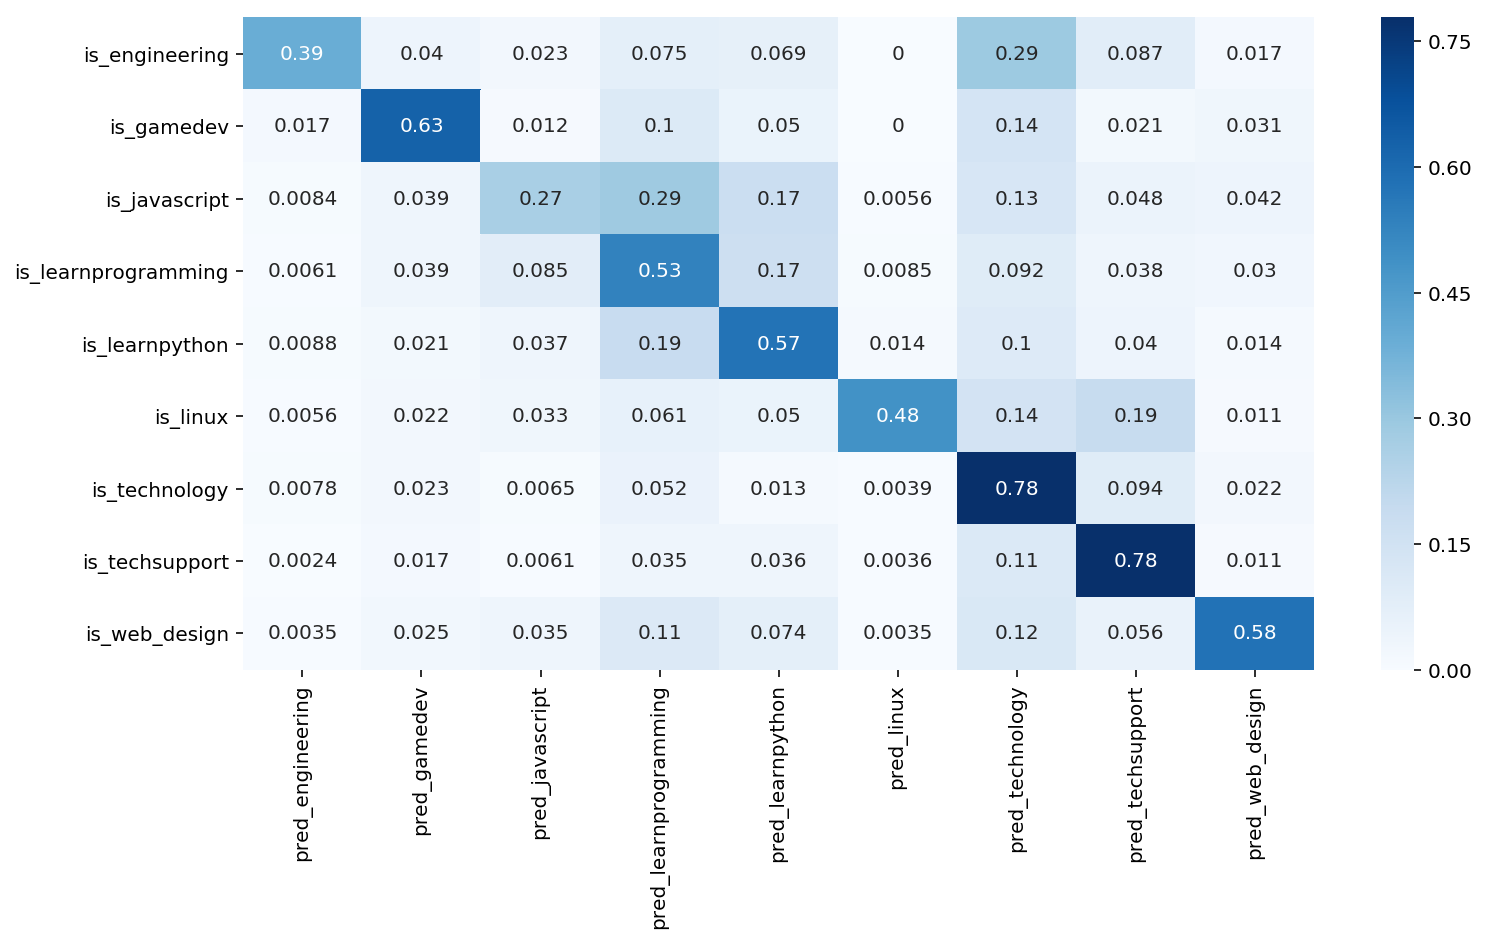

In [36]:
plt.subplots(figsize=(12,6))
sns.heatmap(confusion.apply(lambda x: x/x.sum(),axis=1), annot=True, cmap = 'Blues')
None

<a id='downsampled gbc'></a>
# Downsampled Gradient Boosting Classifier

In [37]:
gbc_gs.fit(Xdown_train, ydown_train)

print("Best Score: ",gbc_gs.best_score_)
print("Best Params: ", gbc_gs.best_params_)

Best Score:  0.575120259537
Best Params:  {'gbc__learning_rate': 0.1, 'gbc__min_samples_leaf': 2, 'gbc__n_estimators': 250, 'tfidf__max_features': 3000, 'tfidf__use_idf': False}


In [38]:
print("Train score: ",gbc_gs.score(Xdown_train, ydown_train))
print("Test score: ", gbc_gs.score(Xdown_test, ydown_test))
print(classification_report(ydown_test, gbc_gs.predict(Xdown_test)))

Train score:  0.77693254279
Test score:  0.605496252555
             precision    recall  f1-score   support

          0       0.58      0.40      0.47       173
          1       0.75      0.61      0.67       423
          2       0.51      0.34      0.41       357
          3       0.52      0.56      0.54       825
          4       0.61      0.49      0.55       569
          5       0.70      0.52      0.60       180
          6       0.53      0.76      0.62       766
          7       0.76      0.76      0.76       825
          8       0.61      0.56      0.58       285

avg / total       0.61      0.61      0.60      4403



In [39]:
conmat = np.array(confusion_matrix(ydown_test, gbc_gs.predict(Xdown_test)))
confusion = pd.DataFrame(conmat,
                         index = ['is_engineering', 'is_gamedev','is_javascript','is_learnprogramming',
                                  'is_learnpython','is_linux','is_technology','is_techsupport','is_web_design'],
                        columns=['pred_engineering', 'pred_gamedev','pred_javascript','pred_learnprogramming',
                                 'pred_learnpython','pred_linux','pred_technology','pred_techsupport',
                                 'pred_web_design'])
confusion

,pred_engineering,pred_gamedev,pred_javascript,pred_learnprogramming,pred_learnpython,pred_linux,pred_technology,pred_techsupport,pred_web_design
is_engineering,69,3,3,23,6,1,55,11,2
is_gamedev,10,259,6,45,7,4,75,8,9
is_javascript,6,12,121,100,40,3,46,12,17
is_learnprogramming,6,28,71,466,97,9,91,25,32
is_learnpython,9,12,16,146,281,8,67,21,9
is_linux,1,1,1,11,3,94,33,34,2
is_technology,11,13,5,39,5,7,584,80,22
is_techsupport,2,14,7,34,13,7,105,631,12
is_web_design,4,5,7,38,9,1,48,12,161


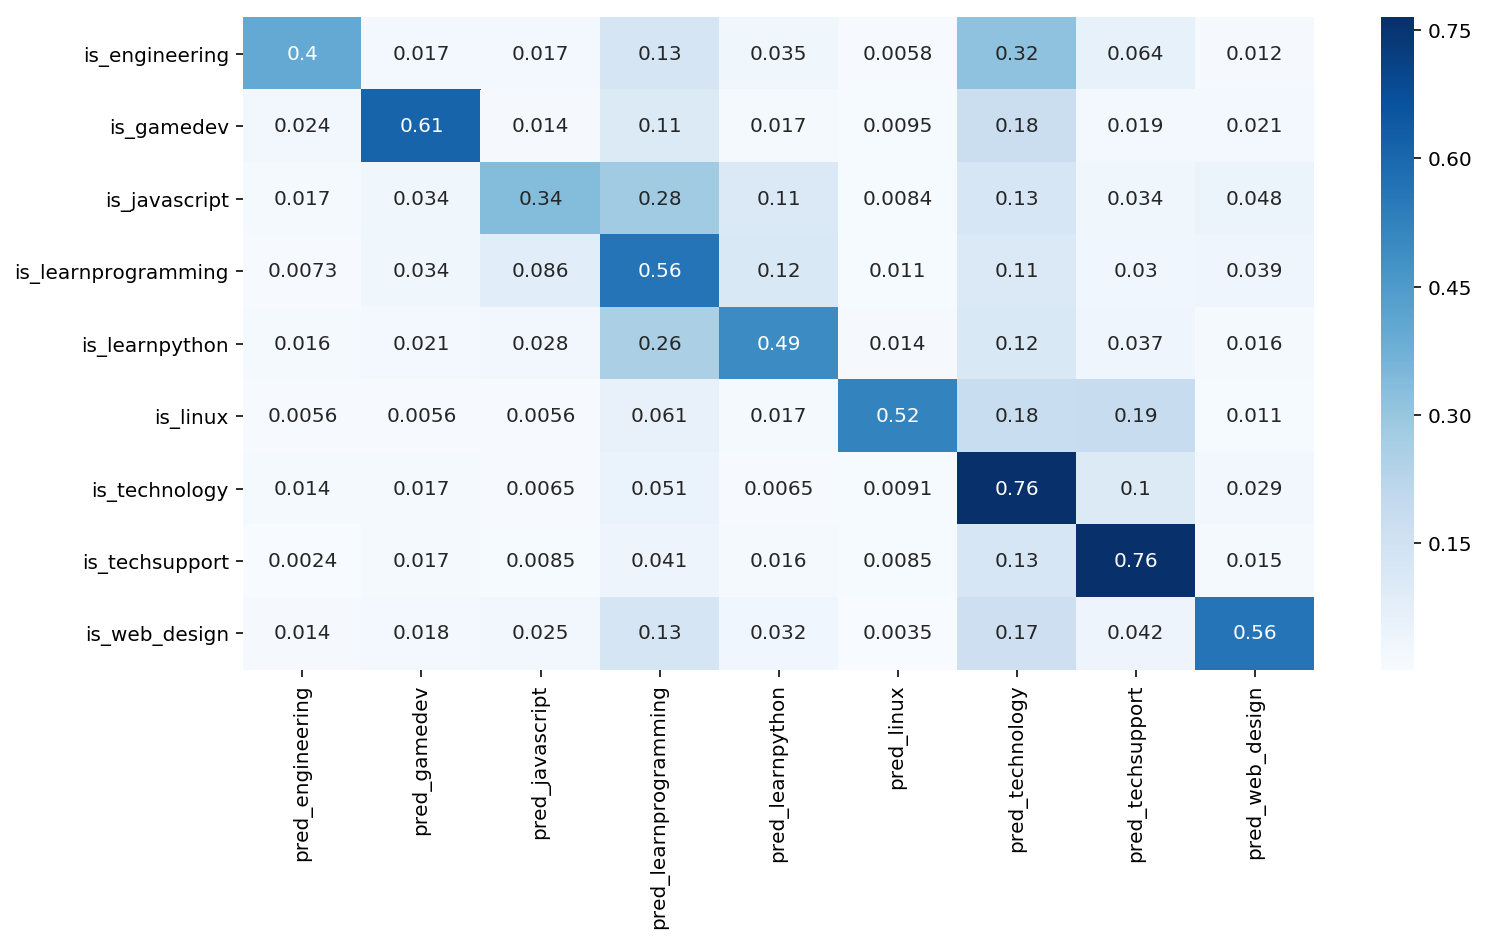

In [40]:
plt.subplots(figsize=(12,6))
sns.heatmap(confusion.apply(lambda x: x/x.sum(),axis=1), annot=True, cmap = 'Blues')
None

<a id='frequency'></a>
# Word Frequency by Subreddit

Below is a visual representations of the word frequency for the top 20 words for each subreddit.
Use the plots to determine common words that are found to understand the misclassifications in the model

If we look at the plotted words for _learn programming_ and _learn python_ we will see that there are a lot of overlapping words. In fact, the 4th most common word in the _learn programming_ subreddit is **python**. The 2nd words for both subreddits are **help**. The overlap between the most frequent words can explain the missclassification of titles belonging in _learn programming_ as _learn python_ and vice versa.

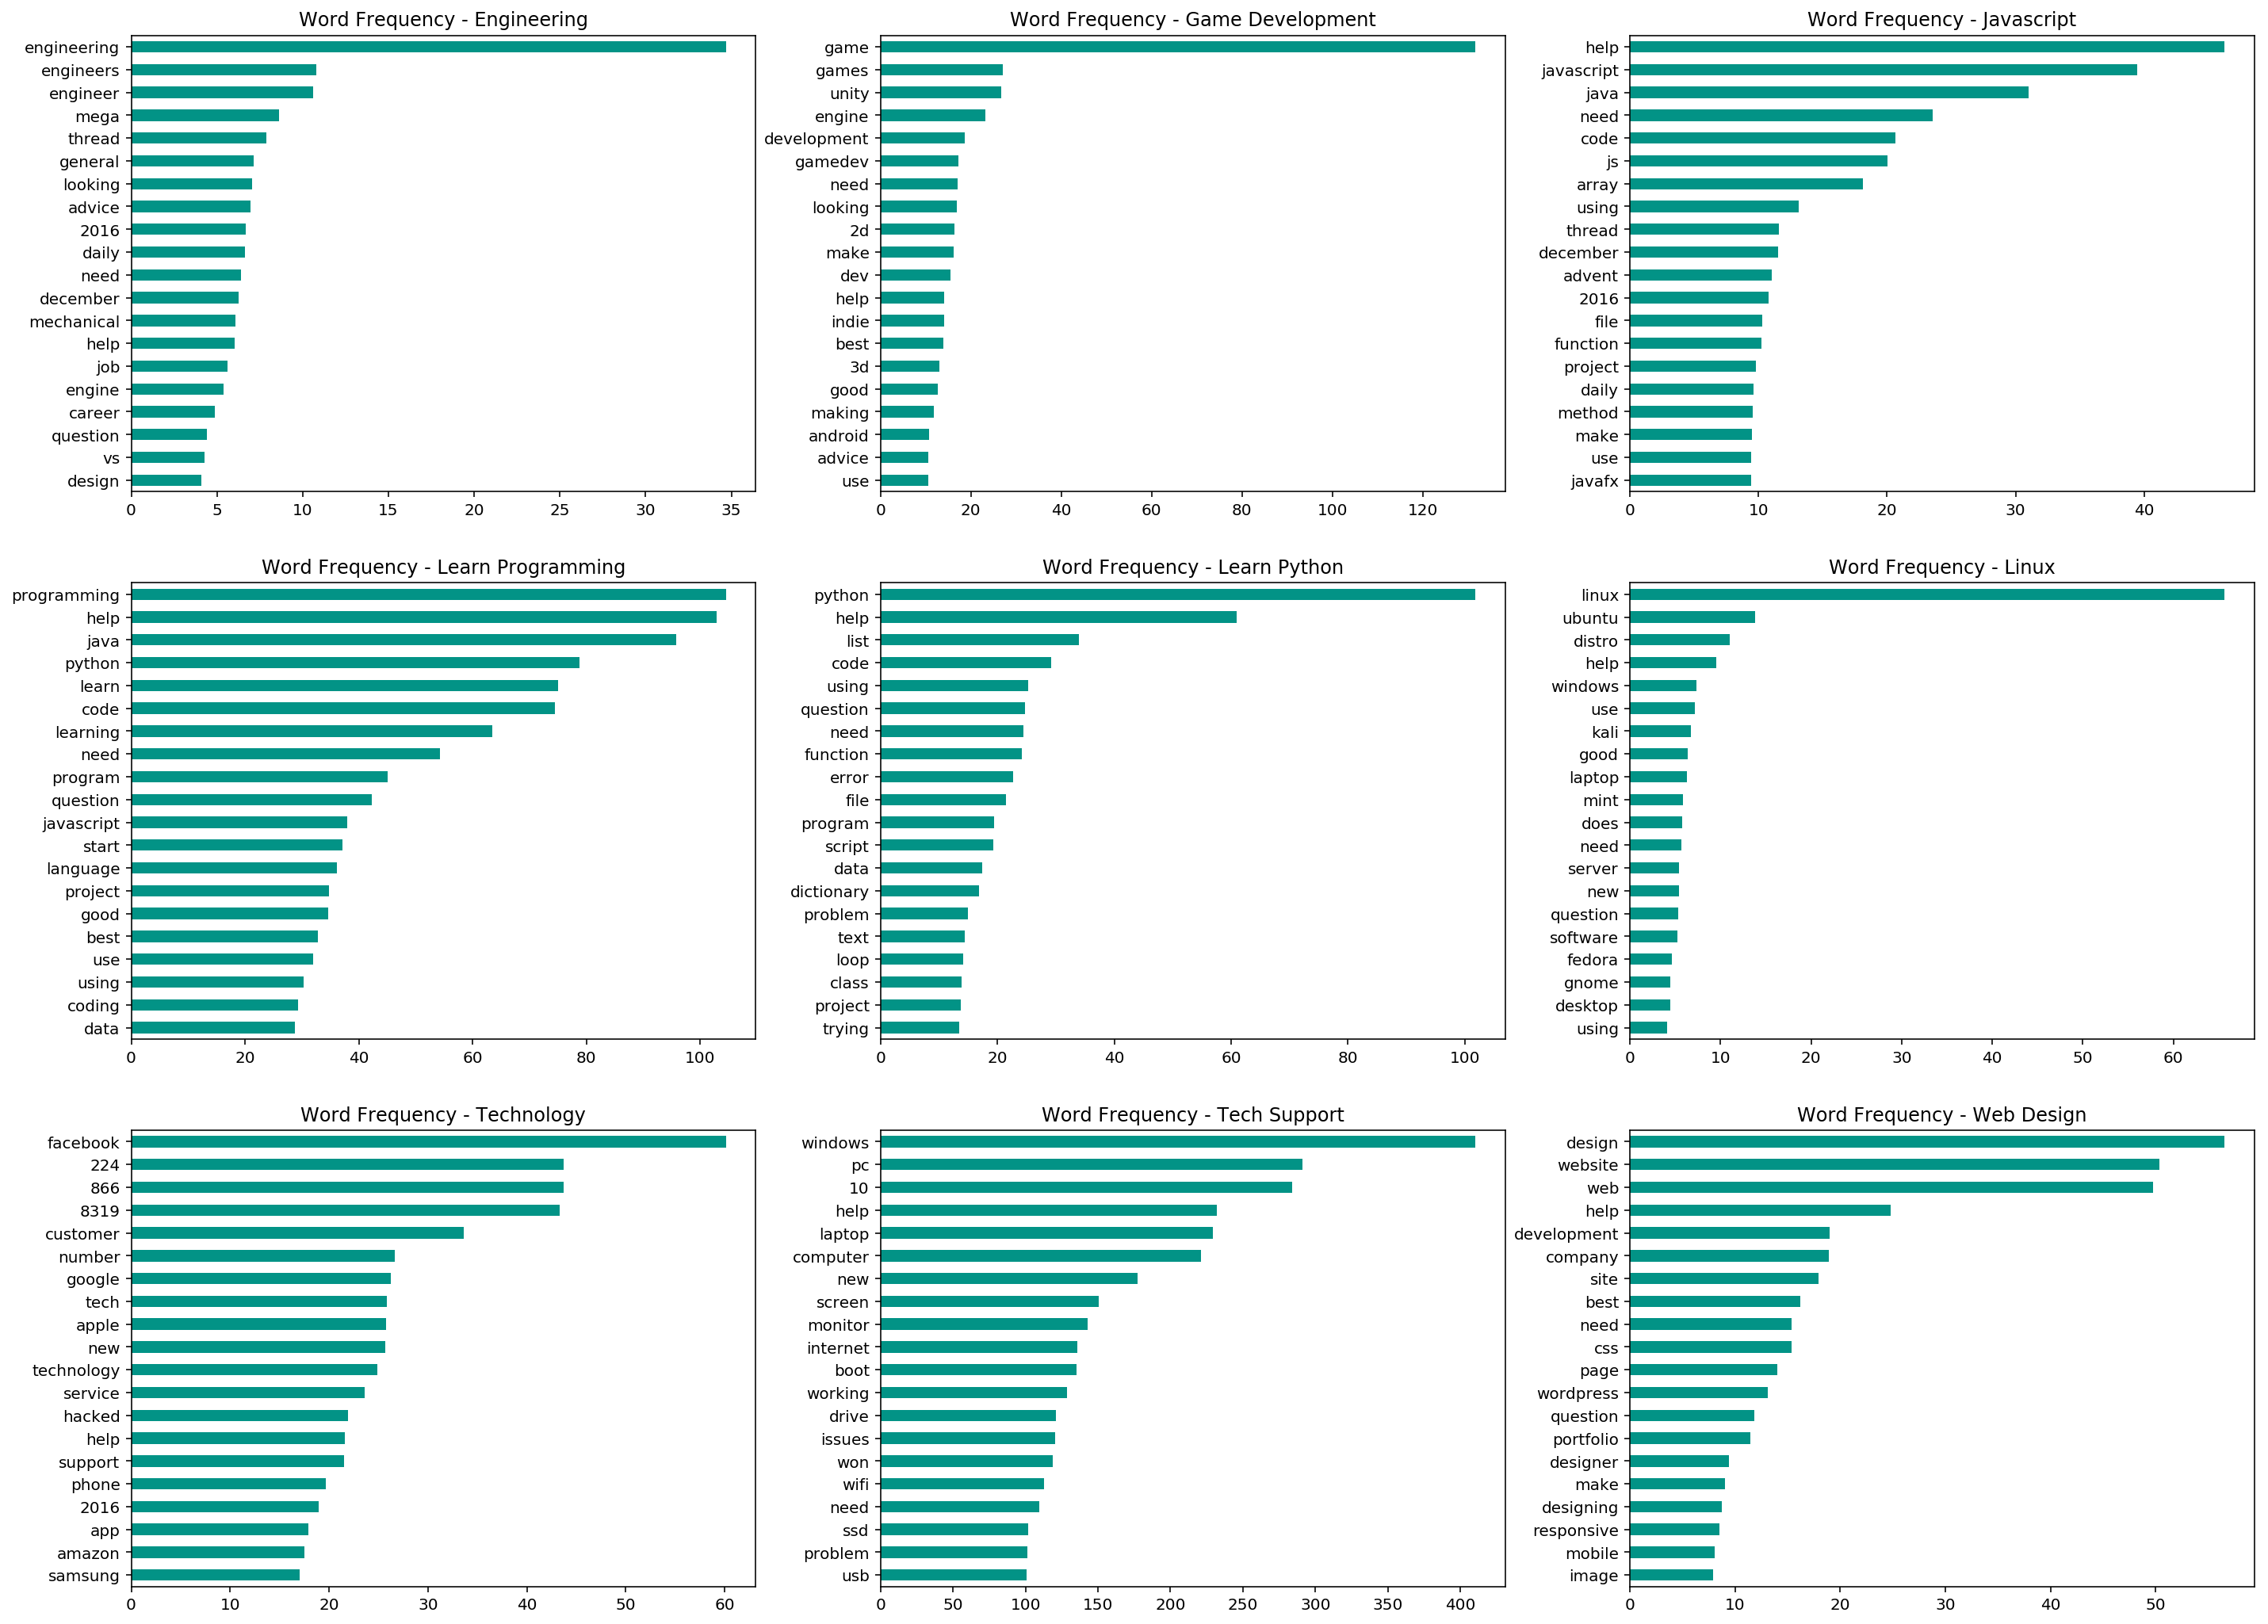

In [41]:
tv = TfidfVectorizer(stop_words='english')
tv.fit(X);

fig = plt.figure(figsize=(24,18))
plt.subplot(3,3,1)
X= df.loc[df['sub_code'] == 0].title
count = pd.DataFrame(tv.transform(X).todense(),columns=tv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='xkcd:teal')
plt.title('Word Frequency - Engineering')

plt.subplot(3,3,2)
X= df.loc[df['sub_code'] == 1].title
count = pd.DataFrame(tv.transform(X).todense(),columns=tv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='xkcd:teal')
plt.title('Word Frequency - Game Development')

plt.subplot(3,3,3)
X= df.loc[df['sub_code'] == 2].title
count = pd.DataFrame(tv.transform(X).todense(),columns=tv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='xkcd:teal')
plt.title('Word Frequency - Javascript')

plt.subplot(3,3,4)
X= df.loc[df['sub_code'] == 3].title
count = pd.DataFrame(tv.transform(X).todense(),columns=tv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='xkcd:teal')
plt.title('Word Frequency - Learn Programming')

plt.subplot(3,3,5)
X= df.loc[df['sub_code'] == 4].title
count = pd.DataFrame(tv.transform(X).todense(),columns=tv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='xkcd:teal')
plt.title('Word Frequency - Learn Python')

plt.subplot(3,3,6)
X= df.loc[df['sub_code'] == 5].title
count = pd.DataFrame(tv.transform(X).todense(),columns=tv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='xkcd:teal')
plt.title('Word Frequency - Linux')

plt.subplot(3,3,7)
X= df.loc[df['sub_code'] == 6].title
count = pd.DataFrame(tv.transform(X).todense(),columns=tv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='xkcd:teal')
plt.title('Word Frequency - Technology')

plt.subplot(3,3,8)
X= df.loc[df['sub_code'] == 7].title
count = pd.DataFrame(tv.transform(X).todense(),columns=tv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='xkcd:teal')
plt.title('Word Frequency - Tech Support')

plt.subplot(3,3,9)
X= df.loc[df['sub_code'] == 8].title
count = pd.DataFrame(tv.transform(X).todense(),columns=tv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='xkcd:teal')
plt.title('Word Frequency - Web Design');

<a id='conclusions'></a>
# Conclusions & Takeaways

The gradient boost classification model that was fit on the downsampled dataset proved to be the best classifier. The downsampled baseline accuracy is 18% and the test accuracy is 60.5%. Both gradient boost models have training scores that are closer to their test scores compared to the random forest models. This suggests that they are less overfit and would probably be more easily generalizable.

The model is not as good at predicting _techsupport_ as previous models; 76% accuracy as opposed to the 78% from the downsampled random forest, 95% from the gradient boost and 96% from the random forest.

The best score occurs when the **use\_idf** parameter for the TFIDF Vectorizer is set to False, effectively making it a CountVectorizer.

                        names  train   test
0               Random Forest  0.964  0.712
1              Gradient Boost  0.834  0.705
2   Downsampled Random Forest  0.969  0.609
3  Downsampled Gradient Boost  0.776  0.605


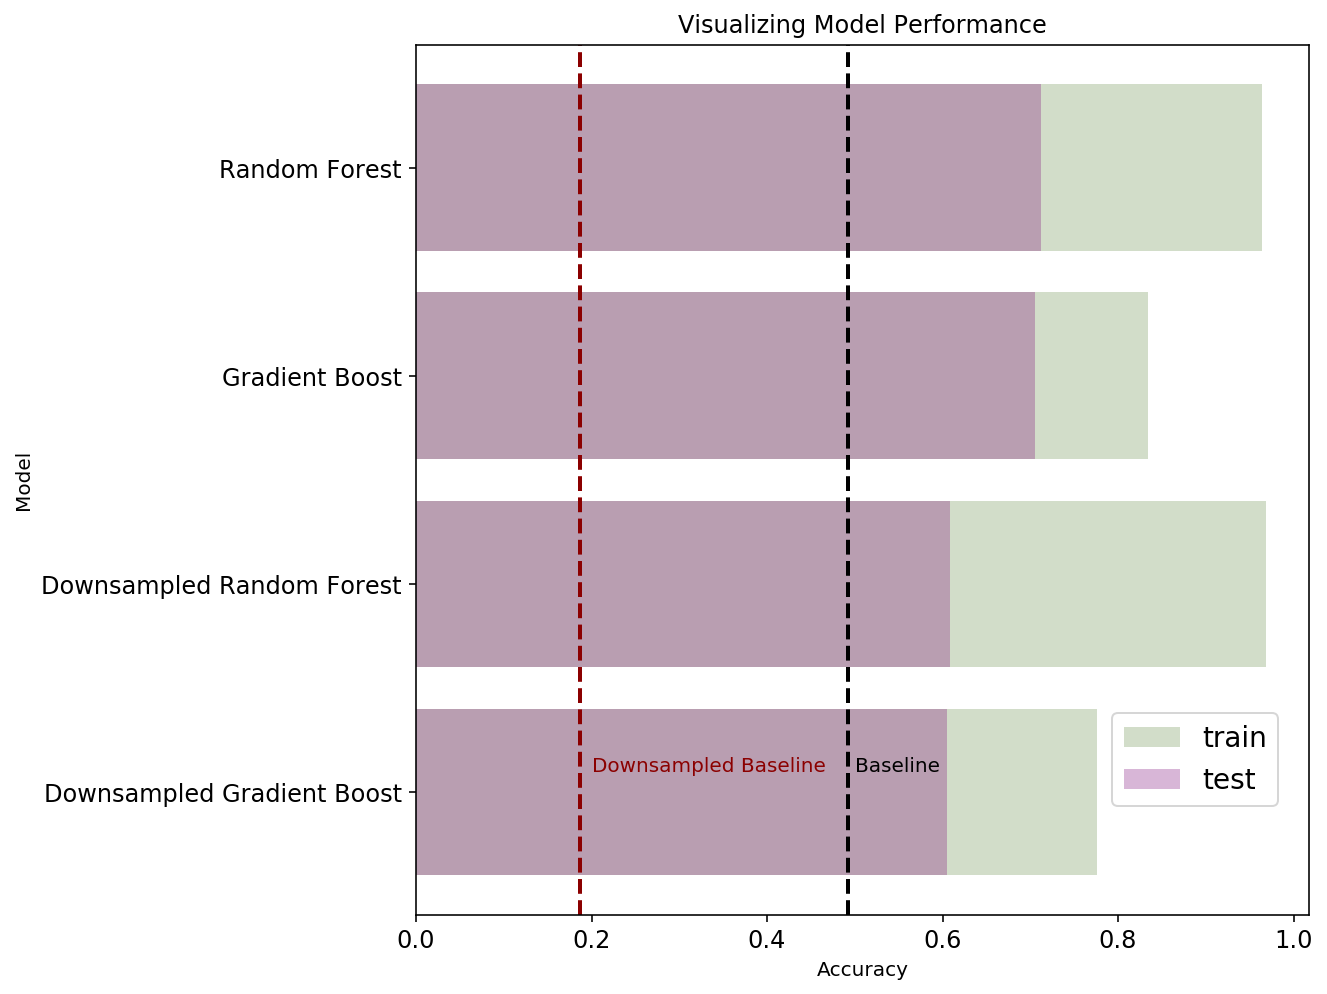

In [42]:
names = ['Random Forest',
        'Gradient Boost',
        'Downsampled Random Forest',
        'Downsampled Gradient Boost']
train = [0.964,
         0.834,
         0.969,
         0.776]
test = [0.712,
       0.705,
       0.609,
       0.605]

accuracy_dct = dict(zip(names, train))

accuracy_df = pd.DataFrame(list(accuracy_dct.items()), columns = ['names','train'])
accuracy_df['test'] = test
print(accuracy_df)

# plot as bar chart

names = accuracy_df['names']

# sort importances
indices = np.argsort(accuracy_df['test'])

# plot as bar chart
fig = plt.figure(figsize=(8, 8))
plt.barh(np.arange(len(names)), accuracy_df['train'][indices], alpha = .3,color = '#6d904f', label = 'train')
plt.barh(np.arange(len(names)), accuracy_df['test'][indices], alpha = .3, color = '#810f7c', label = 'test')
plt.yticks(np.arange(len(names)), np.array(names)[indices], size=12)
plt.xticks(size=12)
_ = plt.ylabel('Model')
_ = plt.xlabel('Accuracy')
_ = plt.title('Visualizing Model Performance')
plt.axvline(x=0.492, color='black', linestyle='--', lw=2)
plt.text(0.5, 0.1, 'Baseline',
        color='black', fontsize=10)
plt.axvline(x=0.187, color='darkred', linestyle='--', lw=2)
plt.text(0.20, 0.1, 'Downsampled Baseline',
        color='darkred', fontsize=10)
plt.legend(loc=(.78, .125), fontsize=14);

In [45]:
tv = TfidfVectorizer(stop_words='english', max_features=3000, use_idf=False)
X_train_tv = tv.fit_transform(Xdown_train)
X_test_tv = tv.transform(Xdown_test)

gbc = GradientBoostingClassifier(learning_rate=0.1, min_samples_leaf=2, n_estimators=250)
gbc.fit(X_train_tv, ydown_train);

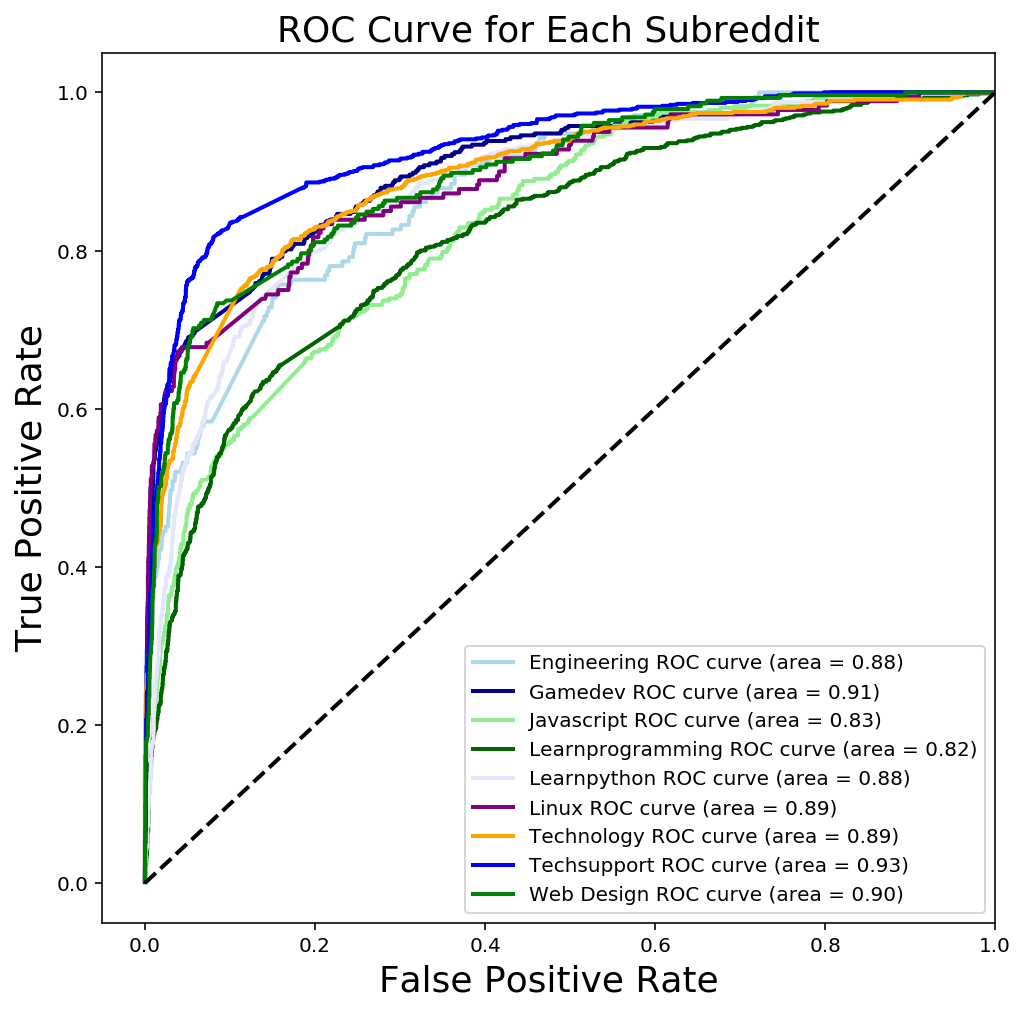

In [46]:
# roc curve
# get y_score for predicted probabilities
y_predict_proba = gbc.predict_proba(X_test_tv)

# generate fpr, tpr, and auc for each class
fpr0, tpr0, thresh0 = roc_curve(ydown_test.map(lambda x: 1 if x == 0 else 0), y_predict_proba[:,0])
roc_auc0 = auc(fpr0, tpr0)

fpr1, tpr1, thresh1 = roc_curve(ydown_test.map(lambda x: 1 if x == 1 else 0), y_predict_proba[:,1])
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, thresh2 = roc_curve(ydown_test.map(lambda x: 1 if x == 2 else 0), y_predict_proba[:,2])
roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, thresh3 = roc_curve(ydown_test.map(lambda x: 1 if x == 3 else 0), y_predict_proba[:,3])
roc_auc3 = auc(fpr3, tpr3)

fpr4, tpr4, thresh4 = roc_curve(ydown_test.map(lambda x: 1 if x == 4 else 0), y_predict_proba[:,4])
roc_auc4 = auc(fpr4, tpr4)

fpr5, tpr5, thresh5 = roc_curve(ydown_test.map(lambda x: 1 if x == 5 else 0), y_predict_proba[:,5])
roc_auc5 = auc(fpr5, tpr5)

fpr6, tpr6, thresh2 = roc_curve(ydown_test.map(lambda x: 1 if x == 6 else 0), y_predict_proba[:,6])
roc_auc6 = auc(fpr6, tpr6)

fpr7, tpr7, thresh7 = roc_curve(ydown_test.map(lambda x: 1 if x == 7 else 0), y_predict_proba[:,7])
roc_auc7 = auc(fpr7, tpr7)

fpr8, tpr8, thresh8 = roc_curve(ydown_test.map(lambda x: 1 if x == 8 else 0), y_predict_proba[:,8])
roc_auc8 = auc(fpr8, tpr8)

# plot all nine together
plt.figure(figsize=[8,8])
plt.plot(fpr0, tpr0, label='Engineering ROC curve (area = %0.2f)' % roc_auc0, linewidth=2, color = 'lightblue')
plt.plot(fpr1, tpr1, label='Gamedev ROC curve (area = %0.2f)' % roc_auc1, linewidth=2, color = 'darkblue')
plt.plot(fpr2, tpr2, label='Javascript ROC curve (area = %0.2f)' % roc_auc2, linewidth=2, color = 'lightgreen')
plt.plot(fpr3, tpr3, label='Learnprogramming ROC curve (area = %0.2f)' % roc_auc3, linewidth=2, color='darkgreen')
plt.plot(fpr4, tpr4, label='Learnpython ROC curve (area = %0.2f)' % roc_auc4, linewidth=2, color = 'lavender')
plt.plot(fpr5, tpr5, label='Linux ROC curve (area = %0.2f)' % roc_auc5, linewidth=2, color = 'purple')
plt.plot(fpr6, tpr6, label='Technology ROC curve (area = %0.2f)' % roc_auc6, linewidth=2, color = 'orange')
plt.plot(fpr7, tpr7, label='Techsupport ROC curve (area = %0.2f)' % roc_auc7, linewidth=2, color = 'blue')
plt.plot(fpr8, tpr8, label='Web Design ROC curve (area = %0.2f)' % roc_auc8, linewidth=2, color = 'green')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC Curve for Each Subreddit', fontsize=18)
plt.legend(loc="lower right")
plt.show()

# Next Steps

As the name implies Term Frequency Inverse Document Frequency can only look at how often a word occurs in a corpus. In order to improve the missclassifications due to commonly occuring words, I want to use Word2Vec to provide context to each word.

I also want to look at different methods of resampling to see how that impacts the  I specifically want to upsample the minority classes